In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
csv_files = ['070.csv', '088.csv', '135.csv', '143.csv', '168.csv', '169.csv', '226.csv', '234.csv', '274.csv', '319.csv', '355.csv']

In [26]:
def fix_outliers_iqr(dataframe):
    for column in dataframe.drop(columns=['Date']).columns:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        dataframe[column] = dataframe[column].apply(lambda x: lower_limit if x < lower_limit else upper_limit if x > upper_limit else x)


In [27]:
def Moving_Avg(df):
    # MOVING AVG
    ma_100_days = df['Close'].rolling(100).mean()
    plt.plot(df['Close'],c='r')
    plt.plot(ma_100_days,c='b')
    plt.show()


In [28]:
from sklearn.preprocessing import MinMaxScaler
def MinMaxScale(x):
    mx = MinMaxScaler(feature_range=(0,1))
    return mx.fit_transform(x), mx.scale_

In [29]:
def x_y_splits_for_Mov_Avg_k(x_inp,k):
    x = []
    y = []

    for i in range(k, x_inp.shape[0]):
        x.append(x_inp[i - k:i])
        y.append(x_inp[i,0])
    x,y = np.array(x),np.array(y)
    
    return x,y

# Keras

In [30]:
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
import tensorflow as tf

def Keras(xtrain_scaled,ytrain,xtest,epochs,batch_size):
    model = Sequential()
# Layers
    model.add(LSTM(units=50,activation='relu',return_sequences=True,input_shape = ((x.shape[1],1))))
    model.add(Dropout(0.2))

    model.add(LSTM(units=60,activation='relu',return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(units=80,activation='relu',return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(units=120,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=1))

    # compile
    model.compile(optimizer="adam",loss="mean_squared_error")

    # fit
    model.fit(xtrain_scaled,ytrain,epochs=epochs,batch_size=batch_size,verbose=1)
    for i in range(100):
        pred = model.predict(np.array([xtest[-100:]]))
        print(pred)
        xtest = np.append(xtest,pred,axis=0)

    # predict : return ytest scaled
    return xtest[-100:]

    

In [31]:
def write_to_csv(y_pred,file):
    data = {'ID': [f"{file[:3]}_#{i}" for i in range(1,101)], 'Price': y_pred.reshape((1,y_pred.shape[0])).ravel()[-100:]}
    df = pd.DataFrame(data)
    write_to = pd.read_csv('BitbyBit.csv')
    updated_df = pd.concat([write_to, df], ignore_index=True)
    updated_df.to_csv('BitbyBit.csv', index=False)

Epoch 1/20
91/91 [==============================] - 20s 176ms/step - loss: 0.0205
Epoch 2/20
91/91 [==============================] - 15s 161ms/step - loss: 0.0064
Epoch 3/20
91/91 [==============================] - 15s 161ms/step - loss: 0.0052
Epoch 4/20
91/91 [==============================] - 15s 161ms/step - loss: 0.0046
Epoch 5/20
91/91 [==============================] - 15s 164ms/step - loss: 0.0054
Epoch 6/20
91/91 [==============================] - 15s 162ms/step - loss: 0.0052
Epoch 7/20
91/91 [==============================] - 15s 161ms/step - loss: 0.0041
Epoch 8/20
91/91 [==============================] - 15s 161ms/step - loss: 0.0039
Epoch 9/20
91/91 [==============================] - 15s 162ms/step - loss: 0.0039
Epoch 10/20
91/91 [==============================] - 15s 162ms/step - loss: 0.0038
Epoch 11/20
91/91 [==============================] - 15s 161ms/step - loss: 0.0038
Epoch 12/20
91/91 [==============================] - 15s 162ms/step - loss: 0.0032
Epoch 13/20
9

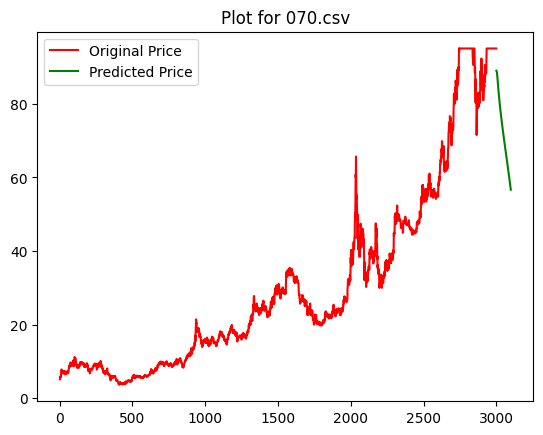

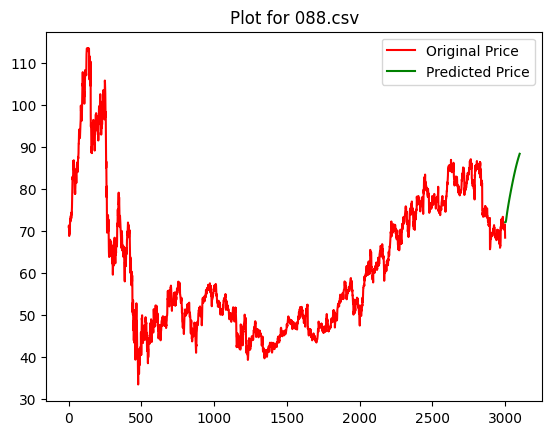

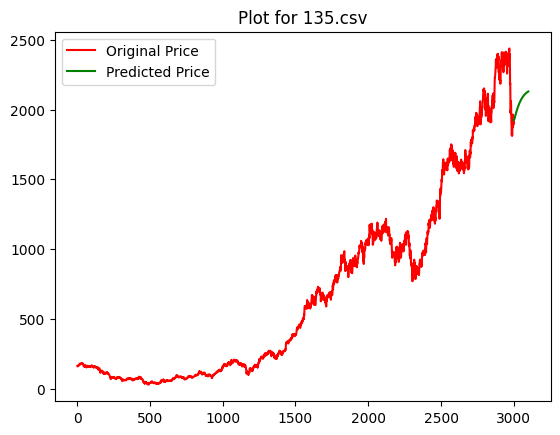

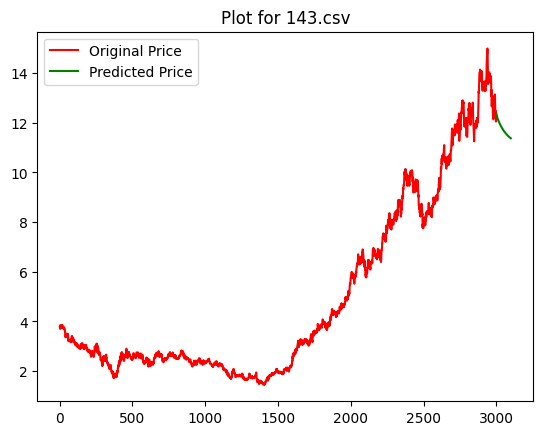

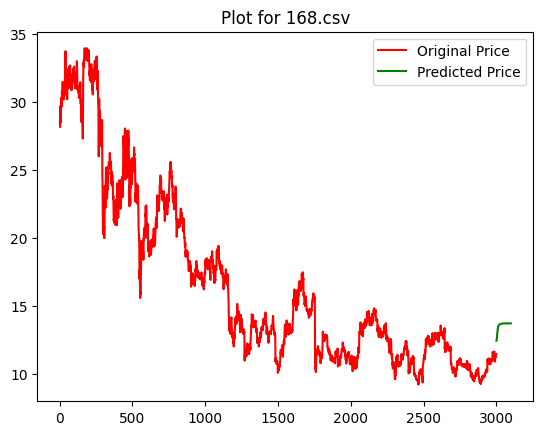

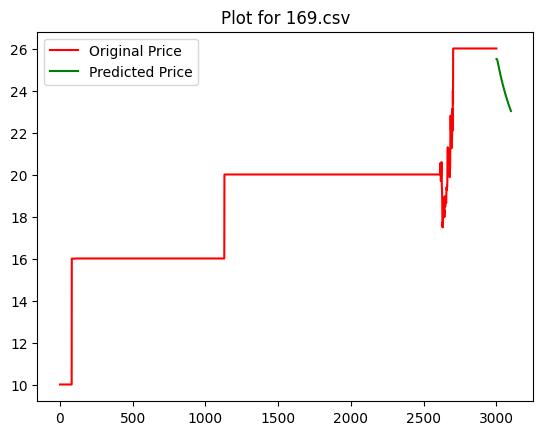

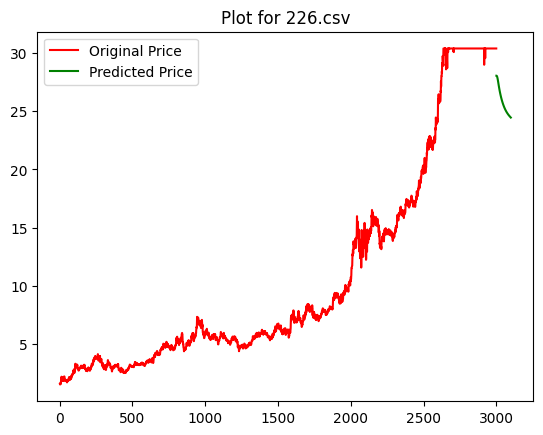

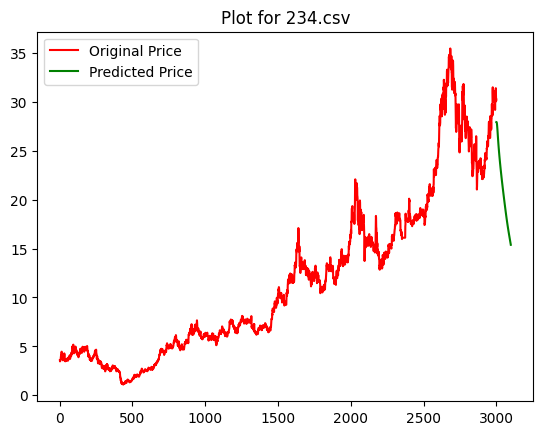

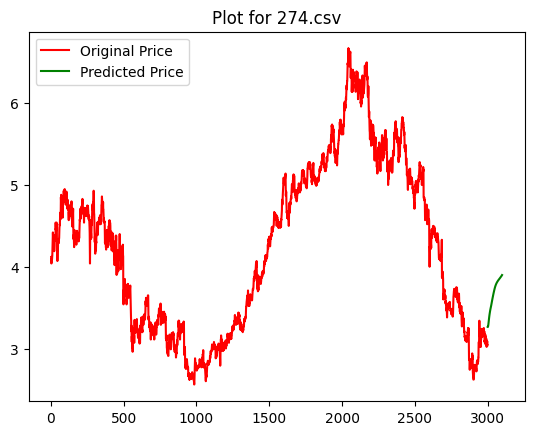

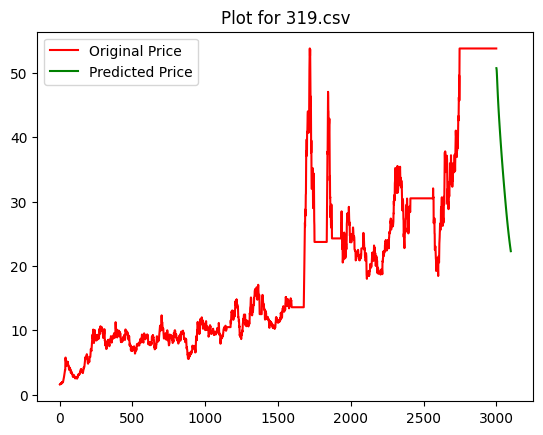

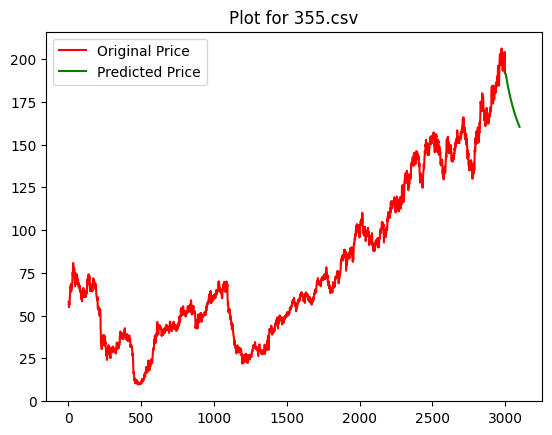

In [32]:
for csv in csv_files:
    df = pd.read_csv(f'./mine-the-model-2023/Upload-Dataset/TRAIN/{csv}').drop(columns=['Dividends','Stock Splits'])
    df['Date']=pd.to_datetime(df['Date'])
    df = df.reset_index(drop=True)
    df.dropna(inplace=True)
    # Fix Outliers
    fix_outliers_iqr(df)

    # Moving Avg
    # Moving_Avg(df)

    mx = MinMaxScaler(feature_range=(0,1))

    Close = mx.fit_transform(np.array(df['Close']).reshape(-1,1))
    # Split
    # split_ratio = 0.9
    # split_index = int(split_ratio * len(Close))
    xtrain = pd.DataFrame(Close)
    xtest= pd.DataFrame(Close[-100:])
    # scale = mx.scale_
    # Train
    x = []
    y = []
    for i in range(100, xtrain.values.shape[0]):
        x.append(xtrain.values[i - 100:i])
        y.append(xtrain.values[i,0])

    x,y = np.array(x),np.array(y)
    # Predict and scale up
    ypred = Keras(x,y,xtest,epochs=20,batch_size=32)
    # Plots Save
    plt.figure()
    plt.plot([i for i in range(1,3001)], mx.inverse_transform(xtrain), 'r', label = 'Original Price')
    plt.plot([i for i in range(3001,3101)],mx.inverse_transform(ypred) , 'g', label = 'Predicted Price')
    plt.legend()
    plt.title(f"Plot for {csv}")
    plt.savefig(f'./Plots/{csv[:3]}')

    # Into Csv
    write_to_csv(mx.inverse_transform(ypred),csv)